## order of procedures:
- apply low pass filter (Gaussian): std dev = sqrt(2/(4*tau)), tau in [0,1]
- downsampling the images via LK / HS
- apply bicubic interpolation
- flow estimation from coarse to fine

# low-pass (blurring) Gaussian filter

In [1]:
from math import sqrt
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2

guassian filter's std dev\
![std dev](mrkdn_pics\gauss_std_dev.png)

factor tau\
![t_tau](mrkdn_pics\gauss_std_dev_tau.png)

review the next formula

In [2]:
t = 0.1  # tau -> [0..1]
gauss_std_dev = sqrt(2/(4*t))

(512, 512)


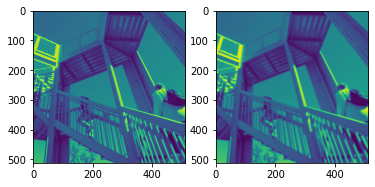

In [9]:
from scipy import misc
import matplotlib.pyplot as plt

fig = plt.figure()

# plt.gray()  # show the filtered result in grayscale

ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

# imga = cv2.imread(r'Other_imgs\cover.jpg')
# image_rgb = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)

ascent = misc.ascent()

print(ascent.shape)
ax1.imshow(ascent)

ascent = np.array(ascent, np.uint8)  # convert img to np.array
blur = cv2.GaussianBlur(src=ascent, ksize=(5,5), sigmaX=gauss_std_dev)  # using opencv (cv2)
ax2.imshow(blur)

plt.show()

# bicubic interpolation
https://github.com/rootpine/Bicubic-interpolation

In [6]:
# !git clone https://github.com/rootpine/Bicubic-interpolation.git

In [5]:
import cv2
import numpy as np
import math
import sys, time

In [6]:
# Interpolation kernel
def u(s,a):
    if (abs(s) >=0) & (abs(s) <=1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

In [9]:
#Paddnig
def padding(img,H,W,C):
    zimg = np.zeros((H+4,W+4,C))
    zimg[2:H+2,2:W+2,:C] = img
    #Pad the first/last two col and row
    zimg[2:H+2,0:2,:C]=img[:,0:1,:C]
    zimg[H+2:H+4,2:W+2,:]=img[H-1:H,:,:]
    zimg[2:H+2,W+2:W+4,:]=img[:,W-1:W,:]
    zimg[0:2,2:W+2,:C]=img[0:1,:,:C]
    #Pad the missing eight points
    zimg[0:2,0:2,:C]=img[0,0,:C]
    zimg[H+2:H+4,0:2,:C]=img[H-1,0,:C]
    zimg[H+2:H+4,W+2:W+4,:C]=img[H-1,W-1,:C]
    zimg[0:2,W+2:W+4,:C]=img[0,W-1,:C]
    return zimg

In [10]:
# https://github.com/yunabe/codelab/blob/master/misc/terminal_progressbar/progress.py
def get_progressbar_str(progress):
    END = 170
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))

In [11]:
# Bicubic operation
def bicubic(img, ratio, a):
    #Get image size
    H,W,C = img.shape

    img = padding(img,H,W,C)
    #Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
    dst = np.zeros((dH, dW, 3))

    h = 1/ratio

    print('Start bicubic interpolation')
    print('It will take a little while...')
    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2 , j * h + 2

                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x

                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1,a),u(x2,a),u(x3,a),u(x4,a)]])
                mat_m = np.matrix([[img[int(y-y1),int(x-x1),c],img[int(y-y2),int(x-x1),c],img[int(y+y3),int(x-x1),c],img[int(y+y4),int(x-x1),c]],
                                   [img[int(y-y1),int(x-x2),c],img[int(y-y2),int(x-x2),c],img[int(y+y3),int(x-x2),c],img[int(y+y4),int(x-x2),c]],
                                   [img[int(y-y1),int(x+x3),c],img[int(y-y2),int(x+x3),c],img[int(y+y3),int(x+x3),c],img[int(y+y4),int(x+x3),c]],
                                   [img[int(y-y1),int(x+x4),c],img[int(y-y2),int(x+x4),c],img[int(y+y3),int(x+x4),c],img[int(y+y4),int(x+x4),c]]])
                mat_r = np.matrix([[u(y1,a)],[u(y2,a)],[u(y3,a)],[u(y4,a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m),mat_r)

                # Print progress
                inc = inc + 1
                sys.stderr.write('\r\033[K' + get_progressbar_str(inc/(C*dH*dW)))
                sys.stderr.flush()
    sys.stderr.write('\n')
    sys.stderr.flush()
    return dst

In [ ]:
# Read image
img = cv2.cvtColor(blur, cv2.COLOR_RGB2BGR)
#img = cv2.imread(r'Other_imgs\cover.jpg')
# print(type(img))

# Scale factor
ratio = 2
# Coefficient
a = -1/2

dst = bicubic(img, ratio, a)
print('Completed!')
cv2.imwrite('blur.png', dst)

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# # from mpl_toolkits import mplot3d
# from scipy import interpolate
# # import sympy as syp
# import pandas as pd
# # pd.options.display.max_colwidth = 200
# # %matplotlib inline

In [13]:
# img = cv2.cvtColor(blur, cv2.COLOR_RGB2BGR)

In [14]:
# img

array([[[ 82,  82,  82],
        [ 82,  82,  82],
        [ 83,  83,  83],
        ...,
        [117, 117, 117],
        [117, 117, 117],
        [117, 117, 117]],

       [[ 82,  82,  82],
        [ 82,  82,  82],
        [ 83,  83,  83],
        ...,
        [117, 117, 117],
        [117, 117, 117],
        [117, 117, 117]],

       [[ 82,  82,  82],
        [ 82,  82,  82],
        [ 83,  83,  83],
        ...,
        [117, 117, 117],
        [117, 117, 117],
        [117, 117, 117]],

       ...,

       [[177, 177, 177],
        [177, 177, 177],
        [177, 177, 177],
        ...,
        [ 54,  54,  54],
        [ 58,  58,  58],
        [ 59,  59,  59]],

       [[178, 178, 178],
        [178, 178, 178],
        [178, 178, 178],
        ...,
        [ 52,  52,  52],
        [ 56,  56,  56],
        [ 58,  58,  58]],

       [[178, 178, 178],
        [178, 178, 178],
        [178, 178, 178],
        ...,
        [ 51,  51,  51],
        [ 56,  56,  56],
        [ 57,  57,  57]]

In [19]:
# img.shape

(512, 512, 3)

In [18]:
# plt.figure(figsize=(4,4))
# plt.pcolormesh(img)
# plt.show

In [24]:
# x_j, y_j = np.arange(img.shape[1]), np.arange(img.shape[0])

# xv, yv = np.meshgrid(x_j, y_j)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [23]:
# xv

array([[  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511],
       ...,
       [  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511]])

ValueError: too many values to unpack (expected 2)

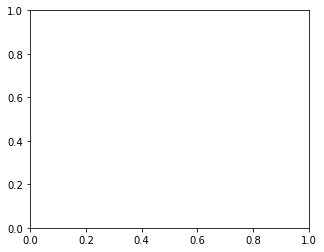

In [21]:
# plt.figure(figsize=(5,4))
# plt.pcolormesh(xv, yv, img)
# plt.show()

In [5]:
# def f(x,y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))

# x = np.linspace(-6, 6, 11)
# # print(x)
# y = np.linspace(-6, 6, 11)

# xx, yy = np.meshgrid(x, y)

# z = f(xx, yy)

# x_new = np.linspace(-6, 6, 100)
# # print(x_new)
# y_new = np.linspace(-6, 6, 100)

# xx_new, yy_new = np.meshgrid(x_new, y_new)

# #z_new = bicubic_interpolation(x, y, z, x_new, y_new)

# z_true = f(xx_new, yy_new) 


# f_scipy = interpolate.interp2d(x, y, z, kind='cubic')
# # print(f_scipy)
# z_scipy = f_scipy(x_new, y_new)
# # print(z_scipy)

[-6.  -4.8 -3.6 -2.4 -1.2  0.   1.2  2.4  3.6  4.8  6. ]
[-6.         -5.87878788 -5.75757576 -5.63636364 -5.51515152 -5.39393939
 -5.27272727 -5.15151515 -5.03030303 -4.90909091 -4.78787879 -4.66666667
 -4.54545455 -4.42424242 -4.3030303  -4.18181818 -4.06060606 -3.93939394
 -3.81818182 -3.6969697  -3.57575758 -3.45454545 -3.33333333 -3.21212121
 -3.09090909 -2.96969697 -2.84848485 -2.72727273 -2.60606061 -2.48484848
 -2.36363636 -2.24242424 -2.12121212 -2.         -1.87878788 -1.75757576
 -1.63636364 -1.51515152 -1.39393939 -1.27272727 -1.15151515 -1.03030303
 -0.90909091 -0.78787879 -0.66666667 -0.54545455 -0.42424242 -0.3030303
 -0.18181818 -0.06060606  0.06060606  0.18181818  0.3030303   0.42424242
  0.54545455  0.66666667  0.78787879  0.90909091  1.03030303  1.15151515
  1.27272727  1.39393939  1.51515152  1.63636364  1.75757576  1.87878788
  2.          2.12121212  2.24242424  2.36363636  2.48484848  2.60606061
  2.72727273  2.84848485  2.96969697  3.09090909  3.21212121  3.3333

In [ ]:
# fig, ax = plt.subplots(2, 2, sharey=True, figsize=(16,12))

# img0 = ax[0, 0].scatter(xx, yy, c=z, s=100)
# ax[0, 0].set_title('original points')
# fig.colorbar(img0, ax=ax[0, 0], orientation='vertical', shrink=1, pad=0.01)

# # img1 = ax[0, 1].imshow(z_new, vmin=z_new.min(), vmax=z_new.max(), origin='lower',
# #            extent=[x_new.min(), x_new.max(), y_new.max(), y_new.min()])
# # ax[0, 1].set_title('bicubic our code')
# # fig.colorbar(img1, ax=ax[0, 1], orientation='vertical', shrink=1, pad=0.01)


# img2 = ax[1, 0].imshow(z_scipy, vmin=z_scipy.min(), vmax=z_scipy.max(), origin='lower',
#            extent=[x_new.min(), x_new.max(), y_new.max(), y_new.min()])
# ax[1, 0].set_title('bicubic scipy')
# fig.colorbar(img2, ax=ax[1, 0], orientation='vertical', shrink=1, pad=0.01)


# img3 = ax[1, 1].imshow(z_true, vmin=z_true.min(), vmax=z_true.max(), origin='lower',
#            extent=[x_new.min(), x_new.max(), y_new.max(), y_new.min()])
# ax[1, 1].set_title('true model')
# fig.colorbar(img3, ax=ax[1, 1], orientation='vertical', shrink=1, pad=0.01)

# plt.subplots_adjust(wspace=0.05, hspace=0.15)

# plt.show()

# flow estimation